<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Модель-линейной-регрессии" data-toc-modified-id="Модель-линейной-регрессии-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Модель линейной регрессии</a></span></li><li><span><a href="#Модель-древа-решений" data-toc-modified-id="Модель-древа-решений-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Модель древа решений</a></span></li><li><span><a href="#Модель-случайного-леса" data-toc-modified-id="Модель-случайного-леса-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Модель случайного леса</a></span></li><li><span><a href="#Модель-градиентного-бустинга" data-toc-modified-id="Модель-градиентного-бустинга-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Модель градиентного бустинга</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span><ul class="toc-item"><li><span><a href="#Модель-линейной-регрессии" data-toc-modified-id="Модель-линейной-регрессии-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Модель линейной регрессии</a></span></li><li><span><a href="#Модель-древа-решений" data-toc-modified-id="Модель-древа-решений-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Модель древа решений</a></span></li><li><span><a href="#Модель-случайного-леса" data-toc-modified-id="Модель-случайного-леса-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Модель случайного леса</a></span></li><li><span><a href="#Модель-градиентного-бустинга" data-toc-modified-id="Модель-градиентного-бустинга-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>Модель градиентного бустинга</a></span></li><li><span><a href="#Сводный-итог" data-toc-modified-id="Сводный-итог-4.5"><span class="toc-item-num">4.5&nbsp;&nbsp;</span>Сводный итог</a></span></li></ul></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
#библиотеки
import pandas as pd
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt
#всякое
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.seasonal import seasonal_decompose
#модели
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor
#метрики
from sklearn.metrics import mean_squared_error
#константы
RS = 12345

Загрузим данные, за индекс примем столбец со временем; укажем, что у нас там время. Затем отсортируем индексы и выполним ресемплинг по одному часу.

In [2]:
data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
data.sort_index(inplace=True)
data = data.resample('1H').sum()

## Анализ

Теперь проинализируем, что у нас получились за данные. Для этого построим скользящее среднее, размер окна я подберу вручную.

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
num_orders    4416 non-null int64
dtypes: int64(1)
memory usage: 69.0 KB


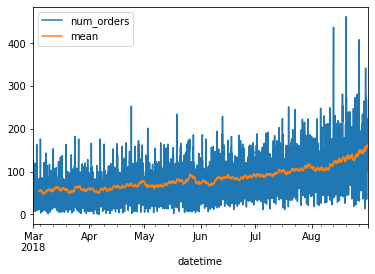

In [4]:
data['mean'] = data['num_orders'].rolling(80).mean()
data.plot()

В данных виден четкий возрастающий тренд, наши данные не стационарны. Чтобы проанализировать цикличность, надо будет взглянуть на данные более укрупненно, например на данные по 1 месяцу.

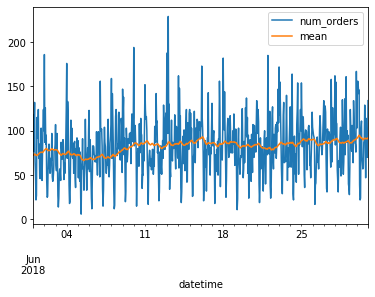

In [5]:
data['2018-06-01':'2018-06-30'].plot()

Есть и цикличность, пики графика через равные промежутки времени выглядят как спады количества заказов в начале суток.

Применим функцию seasonal_decompose к данным и посмотрим на графики отдельных частей.

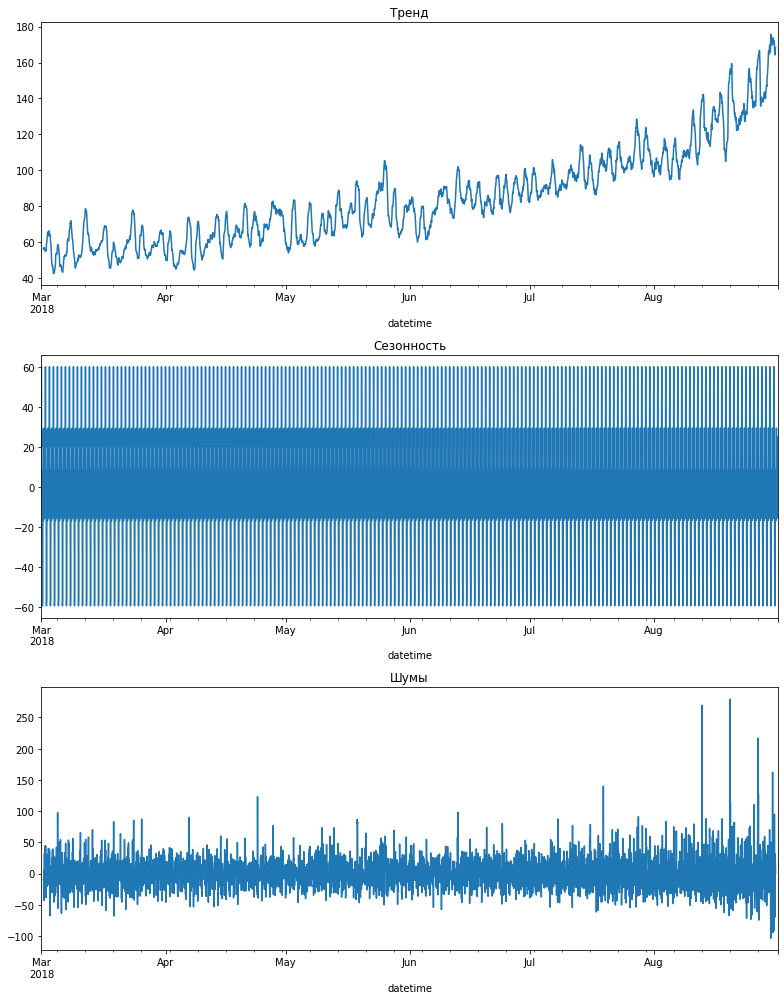

In [6]:
decomposed = seasonal_decompose(data['num_orders'])

plt.figure(figsize=(11, 14))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Сезонность')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Шумы')
plt.tight_layout()

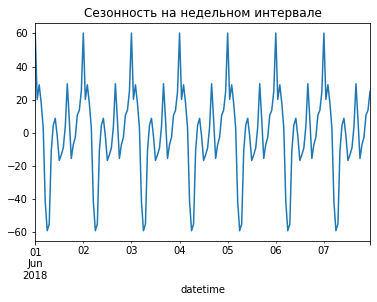

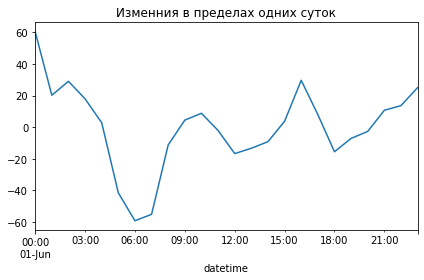

In [7]:
decomposed.seasonal['2018-06-01':'2018-06-07'].plot(ax=plt.gca())
plt.title('Сезонность на недельном интервале')
plt.figure()
decomposed.seasonal['2018-06-01':'2018-06-01'].plot(ax=plt.gca())
plt.title('Изменния в пределах одних суток')
plt.tight_layout()

Выводы можно сделать те же самые:
* возрастающий тренд;
* сезонность посуточная.

## Обучение

Так как нам необходимо опредлить количество поездок, у нас задача регрессии. Применять будем 4 модели:
* LinearRegression
* DecisionTreeRegressor
* RandomForestRegressor
* LGBMRegressor

Для начала подготовим данные. Так как других признаков кроме ключевого у нас нет, нам необходимо создать их. Для этого напишем функцию, аналогичную той, что мы писали в тренажере. Эта функция будет наполнять наш датасет признаками, чтобы на основе них мы могли делать предсказания. 

В признаки мы примем:
* месяц;
* день;
* час;
* день недели;
* скользящее среднее с произвольным размером окна;
* произвольное количество ключевых признаков, каждый со сдвигом на 1 час.

In [8]:
def make_features(data, max_lag, rolling_mean_size):
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['hour'] = data.index.hour
    data['dayofweek'] = data.index.dayofweek
    
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
    return data

Произвольно выберем значения. Скорее всего их потребуется подкорректировать чтобы улучшить результаты предсказаний.

In [9]:
###########################
data_riched = make_features(data, 20, 30)

Теперь поделим все данные на обучающую_валидационную и тестовую выборки, отбросим строки, в которых у нас в результате сдвига образовались пропуски.

После этого отделим целевой признаки и все остальные.

In [10]:
train, test = train_test_split(data_riched, shuffle=False, test_size=0.1, random_state = RS)
train = train.dropna()

features_train = train.drop('num_orders', axis=1)
features_test = test.drop('num_orders', axis=1)

target_train = train['num_orders']
target_test = test['num_orders']

Тем моделям, у которых это возможно, подберем гиперпараметры с помощью кросс-валидации.

### Модель линейной регрессии

In [11]:
model_linear = LinearRegression()
model_linear.fit(features_train, target_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

### Модель древа решений

In [12]:
%%time

parameters = {'max_depth': range(5,20)}
clf_tree = GridSearchCV(DecisionTreeRegressor(), parameters, cv=TimeSeriesSplit(n_splits=5), scoring='neg_mean_squared_error')
clf_tree.fit(features_train, target_train)
print(clf_tree.best_params_)
print(np.sqrt(-clf_tree.best_score_))

{'max_depth': 5}
30.612943309737815
CPU times: user 2.14 s, sys: 17.3 ms, total: 2.16 s
Wall time: 2.23 s


### Модель случайного леса

In [13]:
%%time

parameters = {'max_depth': range(5,20), 'n_estimators': range(5,10)}
clf_forest = GridSearchCV(RandomForestRegressor(), parameters, cv=TimeSeriesSplit(n_splits=5), scoring='neg_mean_squared_error')
clf_forest.fit(features_train, target_train)
print(clf_forest.best_params_)
print(np.sqrt(-clf_forest.best_score_))

{'max_depth': 19, 'n_estimators': 9}
25.71743808812037
CPU times: user 44.8 s, sys: 48.5 ms, total: 44.9 s
Wall time: 45.1 s


### Модель градиентного бустинга

In [14]:
%%time

model_lgbm = LGBMRegressor()
model_lgbm.fit(features_train, target_train)

CPU times: user 1.3 s, sys: 8.99 ms, total: 1.31 s
Wall time: 1.37 s


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

## Тестирование

### Модель линейной регрессии

In [15]:
predict_linear = model_linear.predict(features_test)
rmse_linear = np.sqrt(mean_squared_error(target_test, predict_linear))

print('RMSE модели линейной регрессии равен', rmse_linear)

RMSE модели линейной регрессии равен 46.98955432266113


### Модель древа решений

In [16]:
model_tree = DecisionTreeRegressor(max_depth = clf_tree.best_params_['max_depth'], random_state = RS)
model_tree.fit(features_train, target_train)
predict_tree = model_tree.predict(features_test)
rmse_tree = np.sqrt(mean_squared_error(target_test, predict_tree))
    
print('RMSE модели древа решений равен', rmse_tree)

RMSE модели древа решений равен 59.28841930291553


### Модель случайного леса

In [17]:
model_forest = RandomForestRegressor(max_depth = clf_forest.best_params_['max_depth'], n_estimators = clf_forest.best_params_['n_estimators'], random_state = RS)
model_forest.fit(features_train, target_train)
predict_forest = model_forest.predict(features_test)
rmse_forest = np.sqrt(mean_squared_error(target_test, predict_forest))
    
print('RMSE модели случайного леса равен', rmse_forest)

RMSE модели случайного леса равен 44.653807333875555


### Модель градиентного бустинга

In [18]:
predict_lgbm = model_lgbm.predict(features_test)
rmse_lgbm = np.sqrt(mean_squared_error(target_test, predict_lgbm))

print('RMSE модели градиентного бустинга равен', rmse_lgbm)

RMSE модели градиентного бустинга равен 41.401524567622005


### Сводный итог

In [19]:
pd.DataFrame(data=[rmse_linear, rmse_tree, rmse_forest, rmse_lgbm], index=['LinearRegression', 'DecisionTreeRegressor', 'RandomForestRegressor', 'LGBMRegressor'], columns=['RMSE'])

,RMSE
LinearRegression,46.989554
DecisionTreeRegressor,59.288419
RandomForestRegressor,44.653807
LGBMRegressor,41.401525


В результате мы получили необходимый размер метрики и даже не на одной модели. Если продолжить экспериментировать с количеством добавляемых признаков, я думаю, можно добиться еще меньшей ошибки модели.

Я попробовал несколько разных вариантов дополнения признаков, и что интересно, древо решений ни в одном из вариантов не справилось. Видимо, на подобных задачах линейная регрессия и ансамбли моделей справляются лучше.

Посмотрим на графики полученных предсказаний и сравним их с графиком целевого признака.

In [20]:
predictions = {'LinearRegression' : pd.Series(predict_linear, index=target_test.index),
               'DecisionTreeRegressor' : pd.Series(predict_tree, index=target_test.index), 
               'RandomForestRegressor' : pd.Series(predict_forest, index=target_test.index),
               'LGBMRegressor' : pd.Series(predict_lgbm, index=target_test.index)}

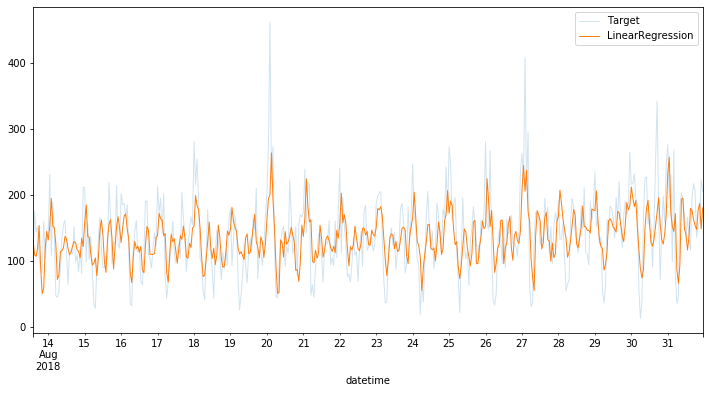

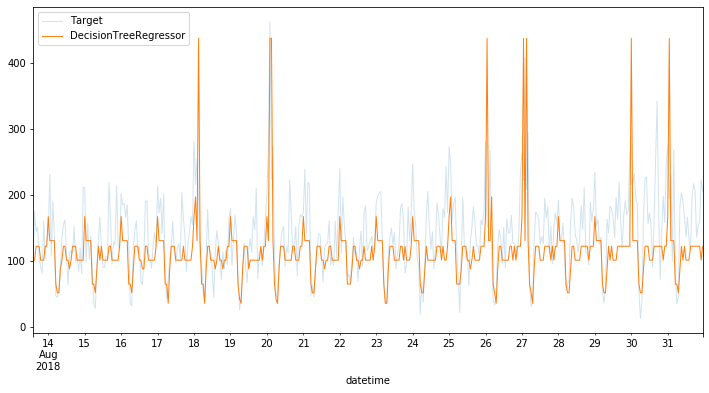

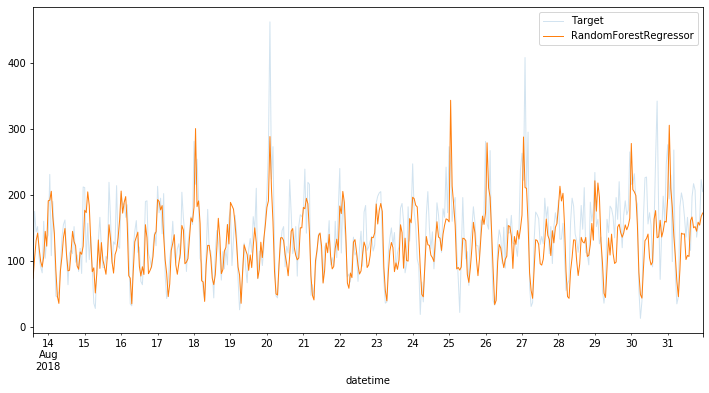

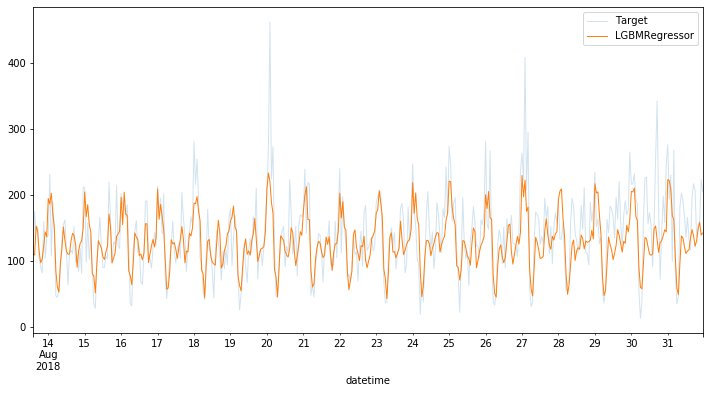

<Figure size 432x288 with 0 Axes>

In [21]:
for key in predictions.keys():
    target_test.plot(linewidth=1, label='Target', legend=True, alpha=.2)
    predictions[key].plot(linewidth=1, label=key, legend=True, figsize=(12, 6))
    plt.figure()

Древо решений делает график слишком квадратным, при этом в местах выбосов давая каки-то заоблачные выбросы. Видимо из-за этого предсказания этой модели и не дают нам необходимой метрики.

Все остальные модели "ведут себя" осторожнее в местах выброса, занижая предсказания в этих точках. При этом если целевые значения не сильно отклоняются от среднего, предсказания оказываются достаточно точными.